# Use Gemini Flash to predict the main address

# Determine stable address with Gemini Flash 2.0

In [2]:
import pandas as pd

clustered_data_with_matched_addresses = pd.read_csv("../datasets/filtered_data_with_matched_addresses.csv")


In [3]:
import pandas as pd


filtered_data = (
    clustered_data_with_matched_addresses
    .sort_values(['caid', 'quarter', 'total_pings'], ascending=[True, True, False])
    .groupby(['caid', 'quarter'])
    .head(5)
    .copy()
)

filtered_data.shape

(158717, 33)

In [4]:
filtered_data

,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,log_total_pings,...,total_weekday_days,weekend_days,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address
0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,3.496508,...,3.0,NaN,3.0,NaN,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9..."
1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,2.302585,...,3.0,1.0,NaN,NaN,0.187500,NaN,1,56158,0,NaN
2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,2.079442,...,3.0,NaN,1.0,NaN,0.145833,NaN,1,66884,0,NaN
3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,4.672829,...,3.0,NaN,2.0,NaN,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9..."
4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,1.945910,...,3.0,NaN,1.0,NaN,0.053571,0.450561,4,55832,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167338,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,8,1,1,1,90068,34.105830,-118.324080,0.693147,...,4.0,1.0,NaN,NaN,0.011111,NaN,1,101720,0,NaN
1167339,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,0,6,3,3,90013,34.047980,-118.247367,1.945910,...,1.0,2.0,1.0,0.666664,0.750000,1.011404,150,32848,1,"400 South Main Street #503, Los Angeles, CA, 9..."
1167340,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,7,1,1,1,90017,34.050070,-118.268740,0.693147,...,1.0,1.0,NaN,NaN,0.125000,NaN,1,51317,0,NaN
1167341,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,8,1,1,1,90068,34.105830,-118.324080,0.693147,...,1.0,1.0,NaN,NaN,0.125000,NaN,1,101720,0,NaN


In [5]:
import os
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed
from pydantic import BaseModel, Field, ValidationError

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI


# ----------------------------
# Load API key and init Gemini
# ----------------------------
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# ----------------------------
# Define output schema
# ----------------------------
class MainClusterSelection(BaseModel):
    main_cluster: int = Field(description="Cluster number selected as main address")
    justification: str = Field(description="Why this cluster was selected")

parser = PydanticOutputParser(pydantic_object=MainClusterSelection)

# ----------------------------
# Prompt template
# ----------------------------
prompt = PromptTemplate(
    template="""
Each user (identified by a CAID) has multiple location clusters detected from mobile signals. Each cluster represents a place where the user spent time during the quarter.

Your task is to select the **main home address cluster** for the user based on the features below. We would like to differentiate from all other addresses, especially from work address.

A main address is usually:
- High **night** or **evening** consistency scores
- High consistency score
- High unique hours, meaning that the user is active at different times of the day
- High max consecutive hours, meaning that the user is active for a long time. 
- Long stays and broad time window coverage
- High dominance score
- High total pings and diverse hourly activity (entropy)

### Column Descriptions

cluster: Cluster index for this user 
consistency_score : % of days (from midnight to midnight) this cluster was seen
night_consistency_score: % of nights this cluster was seen (NaN if no night pings for the device during that quarter)  
evening_consistency_score: % of evenings this cluster was seen (NaN if no evening pings for the device during that quarter)  
day_consistency_score: % of daytime days (between 8am and 8pm)  this cluster was seen (NaN if no day pings for the device during that quarter)  
dominance_score: % of device pings in this cluster  
total_pings: Total number of pings in this cluster  
unique_hours: Number of unique hourly bins this cluster was active  
hour_entropy: Entropy of hourly activity (NaN if too few pings)  
max_consecutive_hours: It is the longest streak of consecutive hourly timestamps where a device was active only in one cluster, ignoring hours with no pings (silent hours).
time_window_coverage: Fraction of [day, evening, night] time windows with activity

---

### Cluster Candidates

{cluster_table}

Choose the main_cluster and explain why.

{format_instructions}
""",
    input_variables=["cluster_table"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

# ----------------------------
# Format one CAID’s cluster group
# ----------------------------
def format_cluster_group(group):
    return "\n".join([
        f"cluster: {row['cluster']}, "
        f"consistency_score: {row['consistency_score']}, "
        f"night_consistency_score: {row['night_consistency_score']}, "
        f"evening_consistency_score: {row['evening_consistency_score']}, "
        f"day_consistency_score: {row['day_consistency_score']}, "
        f"dominance_score: {row['dominance_score']}, "
        f"total_pings: {row['total_pings']}, "
        f"unique_hours: {row['unique_hours']}, "
        f"hour_entropy: {row['hour_entropy']}, "
        f"max_consecutive_hours: {row['max_consecutive_hours']}, "
        f"time_window_coverage: {row['time_window_coverage']}"
        for _, row in group.iterrows()
    ])

# ----------------------------
# LLM call for one user
# ----------------------------
def decide_main_cluster(caid, group):
    try:
        table = format_cluster_group(group)
        output = chain.invoke({"cluster_table": table})
        return {
            "caid": caid,
            "quarter": group.iloc[0]["quarter"],
            "cluster": output.main_cluster,
            "is_main_address_gemini_top5": 1,
            "main_address_justification_gemini_top5": output.justification
        }
    except Exception as e:
        print(f"❌ Error for caid {caid}: {e}")
        return None

# ----------------------------
# Threaded Gemini call for each CAID
# ----------------------------
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(decide_main_cluster, caid, group): caid
        for (caid, quarter), group in filtered_data.groupby(["caid", "quarter"])
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="Gemini (Top 5)"):
        result = future.result()
        if result:
            results.append(result)

# ----------------------------
# Merge results and save
# ----------------------------
df_results = pd.DataFrame(results)
df = filtered_data.merge(df_results, on=["caid", "quarter", "cluster"], how="left")

df["is_main_address_gemini_top5"] = df["is_main_address_gemini_top5"].fillna(0).astype(int)
df["main_address_justification_gemini_top5"] = df["main_address_justification_gemini_top5"].fillna("")

df.to_csv("../datasets/filtered_data_with_main_address_per_user_gemini_all.csv", index=False)
print("✅ Done. Gemini predictions for top 5 clusters per CAID saved.")

Gemini (Top 5): 100%|██████████| 37986/37986 [1:14:00<00:00,  8.56it/s]


✅ Done. Gemini predictions for top 5 clusters per CAID saved.


In [7]:
df.head()

,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_gemini_top5,main_address_justification_gemini_top5
0,0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,...,3.0,NaN,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is the most likely home address beca...
1,1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,...,NaN,NaN,0.187500,NaN,1,56158,0,NaN,0,
2,2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,...,1.0,NaN,0.145833,NaN,1,66884,0,NaN,0,
3,3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,...,2.0,NaN,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is the better choice for the main ho...
4,4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,...,1.0,NaN,0.053571,0.450561,4,55832,0,NaN,0,


In [6]:
df.to_excel("../datasets/filtered_data_with_main_address_per_user_gemini_all.xlsx", index=False)

# Assuming all chosen clusters with a matched address in the first quarter are convincing, we can make a classifier that predicts whether the addresses in subsequent quarters are convincing.

In [12]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_gemini_all.csv")

# ---------------------------
# Feature set
# ---------------------------
features = [
    'day_consistency_score', 'evening_consistency_score', 'night_consistency_score',
    'log_total_pings', 'consistency_score', 'unique_hours', 'max_consecutive_hours',
    'dominance_score', 'time_window_coverage', 'hour_entropy'
]

# ---------------------------
# Define trusted convincing clusters in Q2
# ---------------------------
df_q2 = df[df["quarter"] == 2].copy()
df_q2["is_convincing"] = (
    (df_q2["is_main_address_gemini_top5"] == 1) & 
    (df_q2["matched_address"].notna())
).astype(int)

# Training set = all Q2 clusters (convincing or not)
X_train = df_q2[features]
y_train = df_q2["is_convincing"]

# ---------------------------
# Prediction set: all Q3+ clusters
# ---------------------------
df_q3plus = df[df["quarter"] > 2].copy()

# ---------------------------
# Bayesian tuning with imbalance handling
# ---------------------------
param_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'subsample': Real(0.7, 0.9),
    'colsample_bytree': Real(0.7, 0.9),
    'class_weight': Categorical(['balanced', None])  # ✅ imbalance-aware
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("🔍 Training LGBM Convincingness Classifier...")
model = LGBMClassifier(objective='binary', random_state=42, verbosity=-1)

search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

# ---------------------------
# Predict on Q3+ clusters
# ---------------------------
df_q3plus["convincing_score_predicted"] = best_model.predict_proba(df_q3plus[features])[:, 1]
df_q3plus["is_convincing"] = (df_q3plus["convincing_score_predicted"] > 0.5).astype(int)

# ---------------------------
# Copy known labels for Q2 (just for output consistency)
# ---------------------------
df_q2["convincing_score_predicted"] = df_q2["is_convincing"]  # not predicted, just mirrored

# ---------------------------
# Combine all quarters
# ---------------------------
df_final = pd.concat([df_q2, df_q3plus], ignore_index=True)

# ---------------------------
# Save outputs
# ---------------------------
df_final.to_csv("../datasets/convincingness_scored_all_quarters.csv", index=False)
best_model.booster_.save_model("lgbm_convincing_model_q2.txt")

print("✅ Convincingness predictions saved to: convincingness_scored_all_quarters.csv")
print("💾 Model saved to: lgbm_convincing_model_q2.txt")


🔍 Training LGBM Convincingness Classifier...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 f

In [16]:
# Test
df_final[df_final["quarter"] == 5]

,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_gemini_top5,main_address_justification_gemini_top5,is_convincing,convincing_score_predicted
41064,3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,...,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is the better choice for the main ho...,1,0.926254
41065,4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,...,0.053571,0.450561,4,55832,0,NaN,0,NaN,0,0.002293
41070,22,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,5,7,23,1,2,91402,34.220121,-118.455610,...,0.333333,0.295439,2,56369,0,NaN,1,Cluster 7 has the highest night consistency sc...,0,0.065353
41071,20,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,5,4,12,1,1,90016,34.035942,-118.372146,...,0.173913,NaN,0,71067,0,NaN,0,NaN,0,0.003515
41072,23,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,5,8,9,2,2,90034,34.029532,-118.400348,...,0.130435,0.636514,0,103082,0,NaN,0,NaN,0,0.004309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158708,1167335,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,5,66,1,1,90014,34.040453,-118.246538,...,0.733333,NaN,1,33822,0,NaN,0,NaN,0,0.042925
158709,1167334,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,0,16,4,7,90013,34.047980,-118.247367,...,0.177778,1.721402,63,32848,1,"400 South Main Street #503, Los Angeles, CA, 9...",1,Cluster 0 appears to be the main home address....,1,0.684662
158710,1167336,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,6,6,1,1,90014,34.041305,-118.245833,...,0.066667,NaN,1,33822,0,NaN,0,NaN,0,0.001855
158711,1167337,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,7,1,1,1,90017,34.050070,-118.268740,...,0.011111,NaN,1,51317,0,NaN,0,NaN,0,0.001227


In [17]:
df_final.columns

Index(['Unnamed: 0', 'caid', 'quarter', 'cluster', 'total_pings',
       'unique_days', 'unique_hours', 'zipcode', 'centroid_latitude',
       'centroid_longitude', 'log_total_pings', 'total_days_in_quarter',
       'consistency_score', 'day_consistency_score',
       'evening_consistency_score', 'night_consistency_score',
       'time_window_coverage', 'weekend_focus_score', 'dominance_score',
       'hour_entropy', 'max_consecutive_hours', 'median_income_household_2023',
       'matches_known_address', 'matched_address',
       'is_main_address_gemini_top5', 'main_address_justification_gemini_top5',
       'is_convincing', 'convincing_score_predicted'],
      dtype='object')

# Histogram

## How many caids have a main address that matches an eviction address?

In [18]:
import pandas as pd

# Load your full DataFrame (adjust the path if needed)
df = pd.read_csv("../datasets/convincingness_scored_all_quarters.csv")

# Filter to CAIDs with at least one convincing cluster in Q2
q2_convincing_caids = df[(df["quarter"] == 2)]["caid"].unique()

# Get the number of unique CAIDs
print("✅ Number of unique CAIDs with at least one is_convincing==1 in Q2:", len(q2_convincing_caids))


✅ Number of unique CAIDs with at least one is_convincing==1 in Q2: 6480


## For the ones that matched an eviction address in q2, what percentage of addresses match in subsequent quarters?

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_39651/3533108906.py:50: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


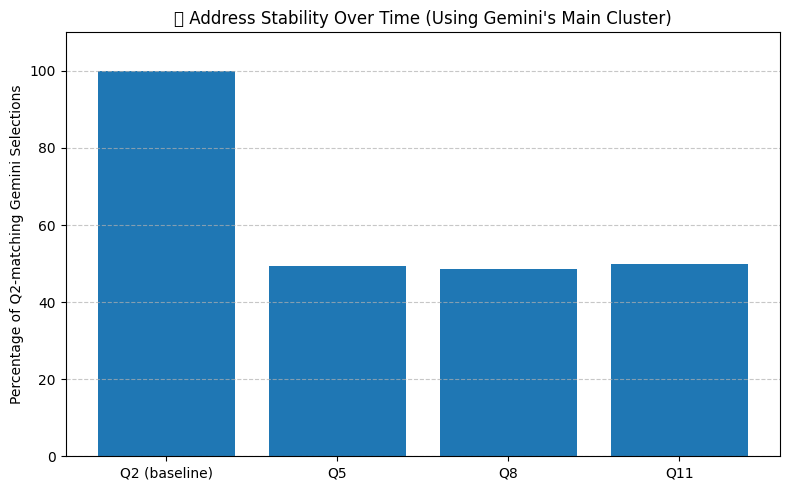

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset (adjust path if needed)
df = pd.read_csv("../datasets/convincingness_scored_all_quarters.csv")

# Step 1: Get baseline CAIDs with is_convincing == 1 in Q2
baseline_caids = df[(df["quarter"] == 2)]["caid"].unique()
df_baseline = df[df["caid"].isin(baseline_caids)]

# Step 2: Use Gemini's selected clusters
def get_gemini_selected_address(df, quarter):
    return (
        df[(df["quarter"] == quarter) & (df["is_main_address_gemini_top5"] == 1)]
        .drop_duplicates("caid")[["caid", "matched_address"]]
        .rename(columns={"matched_address": f"q{quarter}_best_address"})
    )

q2 = get_gemini_selected_address(df_baseline, 2)
q5 = get_gemini_selected_address(df_baseline, 5)
q8 = get_gemini_selected_address(df_baseline, 8)
q11 = get_gemini_selected_address(df_baseline, 11)

# Step 3: Merge addresses
merged = q2.merge(q5, on="caid", how="left") \
           .merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Step 4: Fuzzy address match
def address_match(a, b, tolerance=0):
    if pd.isna(a) or pd.isna(b):
        return False
    return a.strip().lower()[:int(len(a)*tolerance)] in b.strip().lower() or \
           b.strip().lower()[:int(len(b)*tolerance)] in a.strip().lower()

match_q5 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q5_best_address"]), axis=1).mean() * 100
match_q8 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q8_best_address"]), axis=1).mean() * 100
match_q11 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q11_best_address"]), axis=1).mean() * 100

# Step 5: Plot histogram
quarters = ["Q2 (baseline)", "Q5", "Q8", "Q11"]
percentages = [100, match_q5, match_q8, match_q11]

plt.figure(figsize=(8, 5))
plt.bar(quarters, percentages)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Gemini Selections")
plt.title("🏠 Address Stability Over Time (Using Gemini's Main Cluster)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [46]:
df = pd.read_csv("../datasets/convincingness_scored_all_quarters.csv")
df.head(50)


,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_gemini_top5,main_address_justification_gemini_top5,is_convincing,convincing_score_predicted
0,0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,...,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 has the highest dominance score (0.6...,1,1.0
1,1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,...,0.187500,NaN,1,56158,0,NaN,0,NaN,0,0.0
2,2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,...,0.145833,NaN,1,66884,0,NaN,0,NaN,0,0.0
3,10,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,2,1,12,2,2,90016,34.035245,-118.350240,...,0.206897,0.679193,0,71067,1,"5039 BANGOR STREET, LOS ANGELES, CA, 90016",0,NaN,0,0.0
4,11,000c95192187099854c0562841a02cf1185e5dfffd4f6a...,2,2,12,3,2,90016,34.033932,-118.359549,...,0.206897,0.636514,1,71067,0,NaN,1,"Based on the provided data, cluster 2 appears ...",0,0.0


## Taking into account only the convincing addresses

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_68945/2055523163.py:48: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


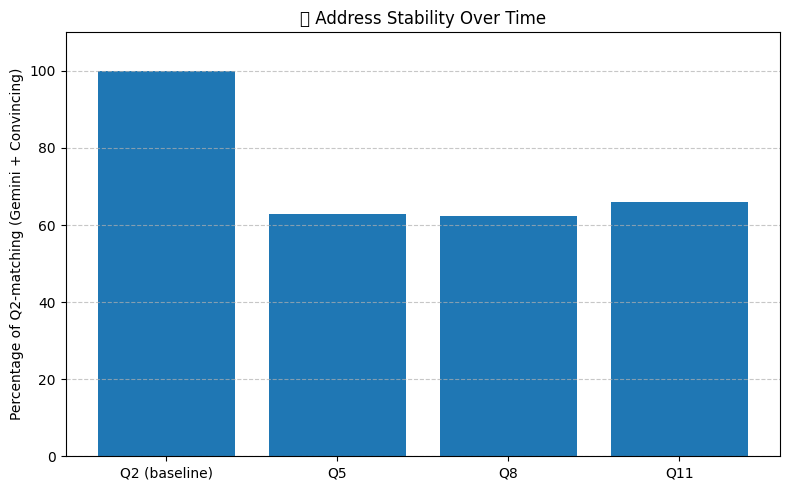

In [25]:
import matplotlib.pyplot as plt

# Step 1: Get baseline CAIDs with is_convincing == 1 in Q2
baseline_caids = df_final[(df_final["quarter"] == 2) & (df_final["is_convincing"] == 1)]["caid"].unique()
df_baseline = df_final[df_final["caid"].isin(baseline_caids)]

# Step 2: Use Gemini + Convincing clusters
def get_valid_convincing_address(df, quarter):
    return (
        df[(df["quarter"] == quarter) &
           (df["is_main_address_gemini_top5"] == 1) &
           (df["is_convincing"] == 1)]
        .drop_duplicates("caid")[["caid", "matched_address"]]
        .rename(columns={"matched_address": f"q{quarter}_best_address"})
    )

q2 = get_valid_convincing_address(df_baseline, 2)
q5 = get_valid_convincing_address(df_baseline, 5)
q8 = get_valid_convincing_address(df_baseline, 8)
q11 = get_valid_convincing_address(df_baseline, 11)

# Step 3: Merge quarterly addresses
merged = q2.merge(q5, on="caid", how="left") \
           .merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Step 4: Address matching
def address_match(a, b, tolerance=0.85):
    if pd.isna(a) or pd.isna(b):
        return False
    return a.strip().lower()[:int(len(a)*tolerance)] in b.strip().lower() or \
           b.strip().lower()[:int(len(b)*tolerance)] in a.strip().lower()

match_q5 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q5_best_address"]), axis=1).mean() * 100
match_q8 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q8_best_address"]), axis=1).mean() * 100
match_q11 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q11_best_address"]), axis=1).mean() * 100

# Step 5: Plot
quarters = ["Q2 (baseline)", "Q5", "Q8", "Q11"]
percentages = [100, match_q5, match_q8, match_q11]

plt.figure(figsize=(8, 5))
plt.bar(quarters, percentages)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching (Gemini + Convincing)")
plt.title("🏠 Address Stability Over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



# Final table

In [66]:
# Use df_final already in memory
df = pd.read_csv("../datasets/convincingness_scored_all_quarters.csv")

# Keep only rows where Gemini selected the cluster AND it's convincing
df = df[(df["is_main_address_gemini_top5"] == 1) & (df["is_convincing"] == 1)]

# Get best address and flags for each quarter
def get_address_summary(df, quarter):
    return (
        df[df["quarter"] == quarter][["caid", "cluster", "is_convincing", "median_income_household_2023"]]
        .rename(columns={
            "cluster": f"q{quarter}_address",
            "is_convincing": f"q{quarter}_is_convincing",
            "median_income_household_2023": f"q{quarter}_income"
        })
    )

q2 = get_address_summary(df, 2)
q5 = get_address_summary(df, 5)
q8 = get_address_summary(df, 8)
q11 = get_address_summary(df, 11)

# Merge on device (CAID)
merged = q2.merge(q5, on="caid", how="left") \
           .merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Define fuzzy matcher (NaN = not a match)
def address_match(a, b):
    if pd.isna(a) or pd.isna(b):
        return False
    return a == b

# Define when user moves
def compute_time_to_move(row):
    if not address_match(row["q2_address"], row["q5_address"]):
        return "Q2 (m5)"
    elif not address_match(row["q2_address"], row["q8_address"]):
        return "Q3 (m8)"
    elif not address_match(row["q2_address"], row["q11_address"]):
        return "Q4 (m11)"
    else:
        return "Stayed same"

merged["time_to_first_move"] = merged.apply(compute_time_to_move, axis=1)
merged["avg_income_q4"] = merged["q11_income"]

# Final output
final_table = merged[[
    "caid",
    "q2_address", "q2_is_convincing",
    "q5_address", "q5_is_convincing",
    "q8_address", "q8_is_convincing",
    "q11_address", "q11_is_convincing",
    "time_to_first_move", "avg_income_q4"
]]






,caid,q2_address,q2_is_convincing,q2_income,q5_address,q5_is_convincing,q5_income,q8_address,q8_is_convincing,q8_income,q11_address,q11_is_convincing,q11_income
0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,0,1,55832,0.0,1.0,55832,0.0,1.0,55832,0.0,1.0,55832
1,0017dae165cbe429683cadd49cf3daa8f7b086307481b6...,0,1,74923,NaN,NaN,NaN,17.0,1.0,71395,43.0,1.0,62655
2,0017fd86fc187c38a3234692832b3ead918bcc91b8e8ca...,1,1,84925,NaN,NaN,NaN,1.0,1.0,84925,1.0,1.0,84925
3,001edb83a43c187506ef6cd3e0965f7d2c29e25f8b3fd2...,0,1,86956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0029931343753fbf875cacd36b30bfb014445d718df7df...,0,1,77925,0.0,1.0,77925,3.0,1.0,77925,0.0,1.0,77925


In [64]:
final_table.head()

,caid,q2_address,q2_is_convincing,q5_address,q5_is_convincing,q8_address,q8_is_convincing,q11_address,q11_is_convincing,time_to_first_move,avg_income_q4
0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,0,1,0.0,1.0,0.0,1.0,0.0,1.0,Stayed same,55832
1,0017dae165cbe429683cadd49cf3daa8f7b086307481b6...,0,1,NaN,NaN,17.0,1.0,43.0,1.0,Q2 (m5),62655
2,0017fd86fc187c38a3234692832b3ead918bcc91b8e8ca...,1,1,NaN,NaN,1.0,1.0,1.0,1.0,Q2 (m5),84925
3,001edb83a43c187506ef6cd3e0965f7d2c29e25f8b3fd2...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,Q2 (m5),NaN
4,0029931343753fbf875cacd36b30bfb014445d718df7df...,0,1,0.0,1.0,3.0,1.0,0.0,1.0,Q3 (m8),77925
